In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

# CSV overview (DATD train & DATD test)

In [ ]:
test = pd.read_csv('datd_test_additional.csv')
nRow, nCol = test.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 550 rows and 2 columns


In [ ]:
test.head(5)

,text,label
0,"ngga enak bgt akhir2 ini rasanya, sering cemas...",1
1,Sedikit khawatir dan gelisah. 😓,1
2,Ngelakuin kesalahan yang sama. Bodoh bgt. Udah...,1
3,"Pantesan gelisah bae, lupa lgi ga ada duit🤭",0
4,Semoga Mei disertai kabar-kabar baik. Yang luk...,0


In [ ]:
train = pd.read_csv('datd_train_additional.csv')
nRow, nCol = train.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 2201 rows and 2 columns


In [ ]:
train.head(5)

,text,label
0,"oh pantesan tadi pada rame, ternyata monek mau...",0
1,"Semakin bertambah usia, semakin cemas hidup.",0
2,gelisah bgt astaga,1
3,Udah jangan terlalu cemas sikapku tak berubah ...,0
4,Giliran Aldebaran diambang kematian...Semua ba...,0


# Text Preprocessing

In [ ]:
import re

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"# flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [ ]:
def process(text):
  # remove links
  text = re.sub("https://t.co/\S*","",text) 

  # remove newline
  text = re.sub("\n","",text)

  # remove digits
  text = re.sub("[0-9]","",text)

  # remove emojis
  text = deEmojify(text)

  return text

## Cleaning Train

In [ ]:
train_corpus = list(map(process, train['text']))    
print(len(train_corpus))
print(train_corpus[1])

2201
Semakin bertambah usia, semakin cemas hidup.


## Cleaning test

In [ ]:
test_corpus = list(map(process, test['text']))    
print(len(test_corpus))
print(test_corpus[1])

550
Sedikit khawatir dan gelisah. 


# Bagi Test Set dan Train Set

In [ ]:
X_train = train_corpus
y_train = train['label'].tolist()

X_test = test_corpus
y_test = test['label'].tolist()

In [ ]:
print(len(X_train[0]))
print(X_train[0])
print(len(X_train))
print(len(y_train))

69
oh pantesan tadi pada rame, ternyata monek mau cb juni. cemas aku tuh
2201
2201


# Building models

In [ ]:
VOCAB_SIZE = 4000

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

## Model 1 (LSTM)

In [ ]:
model_lstm = Sequential()
model_lstm.add(encoder)
model_lstm.add(Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall(name='recall', thresholds=0.9)])

history = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

Epoch 1/15
18/18 [==============================] - 6s 136ms/step - loss: 0.6561 - accuracy: 0.6474 - recall: 0.0314 - val_loss: 0.5457 - val_accuracy: 0.7073 - val_recall: 0.0000e+00
Epoch 2/15
18/18 [==============================] - 1s 61ms/step - loss: 0.5583 - accuracy: 0.6742 - recall: 0.0218 - val_loss: 0.4810 - val_accuracy: 0.7455 - val_recall: 0.1491
Epoch 3/15
18/18 [==============================] - 1s 62ms/step - loss: 0.4498 - accuracy: 0.8224 - recall: 0.5621 - val_loss: 0.4159 - val_accuracy: 0.8164 - val_recall: 0.6335
Epoch 4/15
18/18 [==============================] - 1s 62ms/step - loss: 0.3190 - accuracy: 0.8764 - recall: 0.7954 - val_loss: 0.4276 - val_accuracy: 0.8055 - val_recall: 0.6149
Epoch 5/15
18/18 [==============================] - 1s 63ms/step - loss: 0.2286 - accuracy: 0.9187 - recall: 0.8540 - val_loss: 0.4906 - val_accuracy: 0.8018 - val_recall: 0.5590
Epoch 6/15
18/18 [==============================] - 1s 61ms/step - loss: 0.1626 - accuracy: 0.9441 -

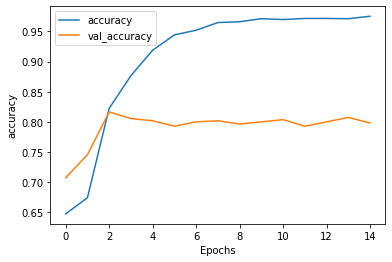

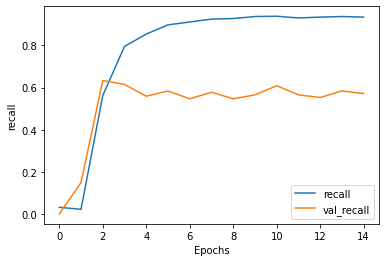

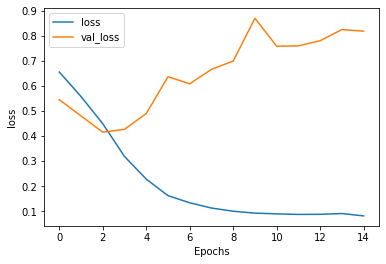

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'recall')
plot_graphs(history, 'loss')

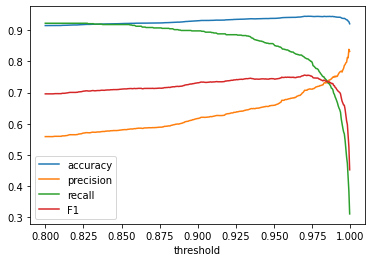

Accuracy: 0.945
Precision: 0.707
Recall: 0.812
F1 score: 0.756
Treshold: 0.97


In [58]:
rand = pd.read_csv('datd_rand_additional.csv')
X_rand = list(map(process, rand['text']))
y_rand = rand['label'].tolist()

def evaluate(y_predict, y_actual, threshold):
  tp = 0
  tn = 0
  fn = 0
  fp = 0
  for k, v in enumerate(y_predict):
    predict = v > threshold
    actual = y_actual[k]

    if actual and not predict:
      fn += 1
    
    if actual and predict:
      tp += 1

    if not actual and predict:
      fp += 1

    if not actual and not predict:
      tn += 1

  accuracy = (tp+tn)/len(y_predict)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = (2*tp)/(2*tp + fp+ fn)
  #print('accuracy:', accuracy)
  #print('precision:', precision)
  #print('recall:', recall)
  #print('f1:', f1)
  return accuracy, precision, recall, f1

def plot_metrics(pred, actual):
  X = np.arange(0.8, 1.0, 0.0005)
  A = []
  P = []
  R = []
  F = []

  for x in X:
    a, p, r, f = evaluate(pred, actual, x)
    A.append(a)
    P.append(p)
    R.append(r)
    F.append(f)

  plt.plot(X, A)
  plt.plot(X, P)
  plt.plot(X, R)
  plt.plot(X, F)
  plt.xlabel("threshold")
  plt.legend(['accuracy', 'precision', 'recall', 'F1'])
  plt.show()

  best = F.index(max(F))
  print("Accuracy: {:.3g}\nPrecision: {:.3g}\nRecall: {:.3g}\nF1 score: {:.3g}\nTreshold: {:.5g}".format(A[best], P[best], R[best], F[best], X[best]))

plot_metrics(model_lstm.predict(X_rand), y_rand)

## Model 2 (Bidirectional)

In [68]:
model_bilstm = tf.keras.Sequential([
    encoder,
    Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=100, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall(name='recall', thresholds=0.9)])
history = model_bilstm.fit(train['text'], train['label'], validation_data=(test['text'], test['label']), epochs=7, batch_size=128)

Epoch 1/7
18/18 [==============================] - 13s 264ms/step - loss: 0.6454 - accuracy: 0.6647 - recall: 0.0000e+00 - val_loss: 0.5360 - val_accuracy: 0.7073 - val_recall: 0.0000e+00
Epoch 2/7
18/18 [==============================] - 3s 142ms/step - loss: 0.5391 - accuracy: 0.6870 - recall: 0.0000e+00 - val_loss: 0.4611 - val_accuracy: 0.7891 - val_recall: 0.0000e+00
Epoch 3/7
18/18 [==============================] - 3s 142ms/step - loss: 0.4186 - accuracy: 0.8423 - recall: 0.0150 - val_loss: 0.4146 - val_accuracy: 0.8200 - val_recall: 0.0870
Epoch 4/7
18/18 [==============================] - 3s 142ms/step - loss: 0.2855 - accuracy: 0.8914 - recall: 0.2920 - val_loss: 0.4540 - val_accuracy: 0.8127 - val_recall: 0.2547
Epoch 5/7
18/18 [==============================] - 3s 144ms/step - loss: 0.1947 - accuracy: 0.9318 - recall: 0.5689 - val_loss: 0.6037 - val_accuracy: 0.8000 - val_recall: 0.3727
Epoch 6/7
18/18 [==============================] - 3s 142ms/step - loss: 0.1515 - accura

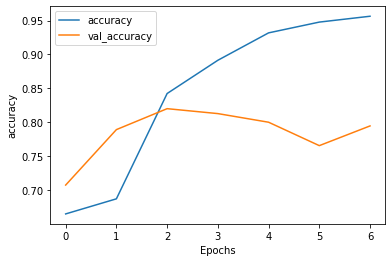

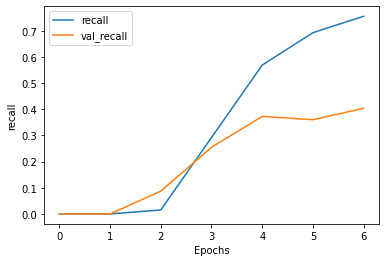

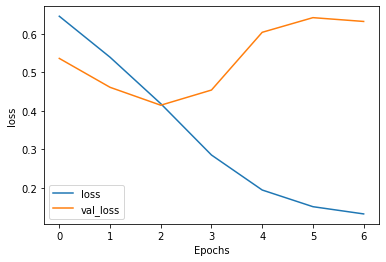

In [69]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'recall')
plot_graphs(history, 'loss')

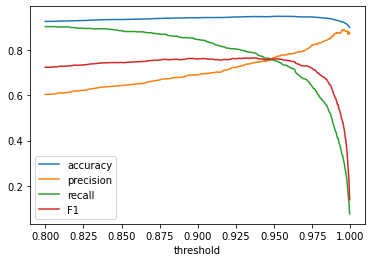

Accuracy: 0.949
Precision: 0.745
Recall: 0.789
F1 score: 0.766
Treshold: 0.936


In [70]:
plot_metrics(model_bilstm.predict(X_rand), y_rand)

In [80]:
model_bilstm.predict(["contoh teks tweet satu",
               "contoh teks tweet dua",
               "contoh teks tweet tiga"])

array([[0.11058763],
       [0.00839627],
       [0.0193885 ]], dtype=float32)

# Results (DATD) with new dataset

We pick the best performance on each model based on the highest F1 score.

Classifier | Accuracy | Precision | Recall | F1 | Threshold
--- | --- | --- | --- | --- | --
LSTM | 0.974 | 0.997 | 0.925 | 0.960 | 0.805
BI-LSTM | 0.977 | 0.999 | 0.932 | 0.964 | 0.800

# Results (DATD+Rand) with new dataset

We pick the best performance on each model based on the highest F1 score.

Classifier | Accuracy | Precision | Recall | F1 | Threshold
--- | --- | --- | --- | --- | --
LSTM | 0.945 | 0.707 | 0.812 | 0.756 | 0.97000
BI-LSTM | 0.949 | 0.745 | 0.789 | 0.766 | 0.93600

In [81]:
model_bilstm.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [82]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/saved_model.pb (deflated 90%)
  adding: model/keras_metadata.pb (deflated 89%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model/variables/variables.index (deflated 64%)
